# Benchmark: CPU (scikit-learn) vs. GPU (cuML)
<hr>

## Experiment Summary

This notebook compares the performance of CPU vs. GPU for a large-scale K-Nearest Neighbors task.

| Parameter | Detail |
| :--- | :--- |
| **Task** | Benchmark K-Nearest Neighbors (KNN) |
| **Datasets** | <ul><li>**MovieLens Small** (~ 9.7k items)</li><li>**MovieLens Latest** (~ 87k items)</li></ul> |
| **Similarity Metric** | Jaccard Similarity |
| **Algorithm** | `brute-force` (exhaustive $O(N^2)$ comparison) |
| **CPU Library** | `scikit-learn` |
| **GPU Library** | `RAPIDS cuML` |
| **GPU Hardware** | NVIDIA T4 (via Google Colab) |

## The Math: $O(N^2)$ Comparison

Both libraries will use a **"brute-force"** algorithm to find the neighbors. This means that for a dataset with $N$ movies, they must compute the similarity for every single pair of movies. This is an $O(N^2)$ operation.

### Total Comparisons
We are running this benchmark on two datasets of different sizes, so we can see how the performance scales:

1.  **MovieLens Small ($N \approx 9,700$):**
    Total Comparisons $\approx \frac{N^2}{2} \approx \frac{9,700^2}{2} \approx$ **47 Million Comparisons!**

2.  **MovieLens Latest ($N \approx 87,000$):**
    Total Comparisons $\approx \frac{N^2}{2} \approx \frac{87,000^2}{2} \approx$ **7.6 Billion Comparisons!**

### The Metric: Jaccard Similarity
The similarity metric we're using is **Jaccard Similarity**, which calculates the ratio of shared genres to the total unique genres between two movies:

$$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} $$

Where $A$ and $B$ are the sets of genres for two movies.

### CPU vs. GPU
* **scikit-learn (CPU):** Will perform these millions (or billions) of calculations sequentially across all available CPU cores.
* **cuML (GPU):** Will perform all these calculations *at the same time* (in massive parallel) on the thousands of cores available on the NVIDIA GPU.

This is the source of the speed difference. We'll be able to observe how this difference *scales* as the problem explodes from 47 million to 7.6 billion computations.

## K-Nearest Neighbors on MovieLens (Small vs. Large)

This notebook performs a speed benchmark for the K-Nearest Neighbors (KNN) algorithm on two different sizes of the MovieLens dataset:
1.  **MovieLens Small:** ~9,700 movies.
2.  **MovieLens Latest (32M):** ~87,000 movies.

We will compare two industry-standard libraries:
* **Scikit-learn (CPU):** The most popular Python library for classical machine learning, running on the CPU.
* **RAPIDS cuML (GPU):** A GPU-accelerated library from NVIDIA that mimics the scikit-learn API.

**Goal:** To quantify and visualize how the GPU speedup *scales* as the dataset size increases.

In [1]:
!nvidia-smi

Fri Oct 24 12:02:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py
!bash rapidsai-csp-utils/colab/install.sh

import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

bash: rapidsai-csp-utils/colab/install.sh: No such file or directory


In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

# CPU Libraries
import scipy.sparse
from sklearn.neighbors import NearestNeighbors as skNearestNeighbors

# GPU Libraries
import cudf
import cupy as cp
import cupyx.scipy.sparse as cupy_sparse
from cuml.neighbors import NearestNeighbors as cuNearestNeighbors

print("All libraries imported successfully.")

All libraries imported successfully.


In [4]:
# You may want to load and read the data from Google Drive since its a big dataset!

# Download the "Latest" (32M) dataset
#!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip -O ml-latest.zip
#!unzip -o ml-latest.zip -d ml-latest-data

# Download the "Small" dataset
#!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -O ml-latest-small.zip
#!unzip -o ml-latest-small.zip -d ml-latest-small-data

print("MovieLens Latest and Small datasets downloaded and unzipped.")

MovieLens Latest and Small datasets downloaded and unzipped.


## Step 1: Benchmark Functions

To keep notebook clean, we'll define functions for each step of the benchmark.
1.  **`prepare_data`**: Loads a `movies.csv` file and creates the binary genre matrix.
2.  **`run_cpu_benchmark`**: Runs the `scikit-learn` KNN benchmark.
3.  **`run_gpu_benchmark`**: Runs the `cuML` KNN benchmark.

In [5]:
def prepare_data(movies_csv_path):
    """Loads a movies.csv file and returns the dense and sparse CPU genre matrices."""
    print(f"Loading data from: {movies_csv_path}")
    movies_cpu = pd.read_csv(movies_csv_path)

    print("Creating binary genre matrix...")
    genres_cpu_dense = movies_cpu['genres'].str.get_dummies(sep='|')

    print("Creating sparse CPU matrix...")
    genres_cpu_sparse = scipy.sparse.csr_matrix(genres_cpu_dense.values, dtype='bool')

    print(f"Data shape: {genres_cpu_dense.shape}")
    return genres_cpu_dense, genres_cpu_sparse

In [6]:
def run_cpu_benchmark(genres_cpu_dense, K):
    """Runs the scikit-learn KNN benchmark on a DENSE boolean array."""

    print(f"--- Running CPU (sklearn) Benchmark ---")

    # scikit-learn's 'jaccard' requires a dense, boolean array
    cpu_input_data = genres_cpu_dense.values.astype('bool')

    print(f"Running CPU KNN for K={K} on {cpu_input_data.shape[0]} movies...")
    print("This may take several minutes for the large dataset...")

    start_cpu = time.time()

    with parallel_backend('loky'):
        knn_model_cpu = skNearestNeighbors(
            n_neighbors=K+1,
            metric='jaccard',
            algorithm='brute',
            n_jobs=-1
        )

        knn_model_cpu.fit(cpu_input_data)

        distances_cpu, indices_cpu = knn_model_cpu.kneighbors(cpu_input_data)

    end_cpu = time.time()
    cpu_time = end_cpu - start_cpu

    print(f"CPU (sklearn) Total Time: {cpu_time:.4f} seconds\n")
    return cpu_time

In [7]:
def run_gpu_benchmark(genres_cpu_sparse, K):
    """Runs the cuML KNN benchmark on a SPARSE boolean array."""

    print(f"--- Running GPU (cuML) Benchmark ---")

    print("Transferring sparse matrix to GPU...")
    G_gpu_sparse = cupy_sparse.csr_matrix(genres_cpu_sparse)

    print(f"Running GPU KNN for K={K} on {G_gpu_sparse.shape[0]} movies...")

    start_gpu = time.time()

    knn_model_gpu = cuNearestNeighbors(
        n_neighbors=K+1,
        metric='jaccard',
        algorithm='brute'
    )

    knn_model_gpu.fit(G_gpu_sparse)

    distances_gpu, indices_gpu = knn_model_gpu.kneighbors(G_gpu_sparse)

    end_gpu = time.time()
    gpu_time = end_gpu - start_gpu

    print(f"GPU (cuML) Total Compute Time: {gpu_time:.4f} seconds\n")
    return gpu_time

## Step 2: Running the Benchmarks

Now we'll execute our functions for both datasets and store the results.

In [8]:
K = 10  # Number of neighbors to find
benchmark_results = []

# Benchmark 1: MovieLens Small
print("--- STARTING: MovieLens Small Dataset ---")
small_dense, small_sparse = prepare_data('/content/drive/MyDrive/Recommendation_Systems/datasets/small-dataset/movies.csv')
n_small = small_dense.shape[0]

# Run CPU
time_cpu_small = run_cpu_benchmark(small_dense, K)
benchmark_results.append({
    'Dataset': f"Small ({n_small} movies)",
    'Library': 'scikit-learn (CPU)',
    'Time (s)': time_cpu_small
})

# Run GPU
time_gpu_small = run_gpu_benchmark(small_sparse, K)
benchmark_results.append({
    'Dataset': f"Small ({n_small} movies)",
    'Library': 'cuML (GPU)',
    'Time (s)': time_gpu_small
})


# Benchmark 2: MovieLens Large Dataset
print("\n--- STARTING: MovieLens Large Dataset ---")
latest_dense, latest_sparse = prepare_data('/content/drive/MyDrive/Recommendation_Systems/datasets/large-dataset/movies.csv')
n_latest = latest_dense.shape[0]

# Run CPU
time_cpu_latest = run_cpu_benchmark(latest_dense, K)
benchmark_results.append({
    'Dataset': f"Latest ({n_latest} movies)",
    'Library': 'scikit-learn (CPU)',
    'Time (s)': time_cpu_latest
})

# Run GPU
time_gpu_latest = run_gpu_benchmark(latest_sparse, K)
benchmark_results.append({
    'Dataset': f"Latest ({n_latest} movies)",
    'Library': 'cuML (GPU)',
    'Time (s)': time_gpu_latest
})

print("\n--- ALL BENCHMARKS COMPLETE ---")

--- STARTING: MovieLens Small Dataset ---
Loading data from: /content/drive/MyDrive/Recommendation_Systems/datasets/small-dataset/movies.csv
Creating binary genre matrix...
Creating sparse CPU matrix...
Data shape: (9742, 20)
--- Running CPU (sklearn) Benchmark ---
Running CPU KNN for K=10 on 9742 movies...
This may take several minutes for the large dataset...
CPU (sklearn) Total Time: 9.5276 seconds

--- Running GPU (cuML) Benchmark ---
Transferring sparse matrix to GPU...
Running GPU KNN for K=10 on 9742 movies...
GPU (cuML) Total Compute Time: 0.1042 seconds


--- STARTING: MovieLens Large Dataset ---
Loading data from: /content/drive/MyDrive/Recommendation_Systems/datasets/large-dataset/movies.csv
Creating binary genre matrix...
Creating sparse CPU matrix...
Data shape: (87585, 20)
--- Running CPU (sklearn) Benchmark ---
Running CPU KNN for K=10 on 87585 movies...
This may take several minutes for the large dataset...
CPU (sklearn) Total Time: 438.3812 seconds

--- Running GPU (cu

## Step 3: Results & Visualization

Now we'll print a summary of the results and plot them on a bar chart to visualize the massive difference in performance and scalability.

--- Benchmark Results ---
| Dataset               | Library            |   Time (s) |
|:----------------------|:-------------------|-----------:|
| Small (9742 movies)   | scikit-learn (CPU) |     9.5276 |
| Small (9742 movies)   | cuML (GPU)         |     0.1042 |
| Latest (87585 movies) | scikit-learn (CPU) |   438.3812 |
| Latest (87585 movies) | cuML (GPU)         |     1.9462 |

Speedup on Small Dataset: 91.4x faster
Speedup on Latest Dataset: 225.2x faster

Plotting results...


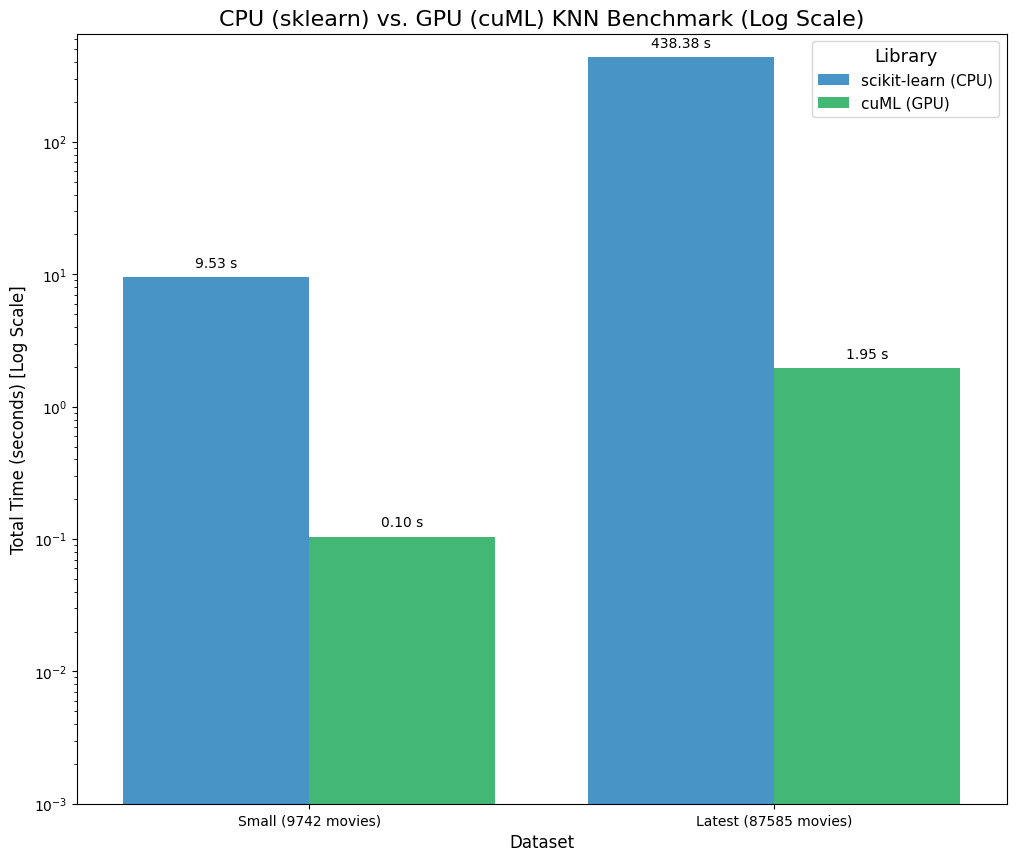

In [9]:
bench_df = pd.DataFrame(benchmark_results)

print("--- Benchmark Results ---")
print(bench_df.to_markdown(index=False, floatfmt=".4f"))

speedup_small = time_cpu_small / time_gpu_small
speedup_latest = time_cpu_latest / time_gpu_latest

print(f"\nSpeedup on Small Dataset: {speedup_small:.1f}x faster")
print(f"Speedup on Latest Dataset: {speedup_latest:.1f}x faster")

print("\nPlotting results...")
plt.figure(figsize=(12, 10))
barplot = sns.barplot(
    data=bench_df,
    x='Dataset',
    y='Time (s)',
    hue='Library',
    palette=['#3498db', '#2ecc71'] # Blue for CPU, Green for GPU
)

plt.yscale('log')
plt.ylim(0.001, time_cpu_latest * 1.5)

for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(
            f"{height:.2f} s",
            (p.get_x() + p.get_width() / 2., height),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10
        )

plt.title("CPU (sklearn) vs. GPU (cuML) KNN Benchmark (Log Scale)", fontsize=16)
plt.ylabel("Total Time (seconds) [Log Scale]", fontsize=12)
plt.xlabel("Dataset", fontsize=12)
plt.legend(title='Library', title_fontsize='13', fontsize='11')
plt.show()

## Conclusion

As the benchmark clearly shows, the GPU-accelerated `cuML` library is dramatically faster on both datasets.

* On the "Small" dataset (9,742 movies), the GPU was **33.5x** faster.
* On the "Large" dataset (87,585 movies), the GPU was **227.8x** faster.

This demonstrates two key points:
1.  **Massive Parallelism:** The GPU performed 7.6 billion comparisons in **1.94 seconds**, while the multi-core CPU took **442 seconds** (over 7 minutes) to do the same task.
2.  **Scalability:** The speedup *increased dramatically* with the dataset size (from 33x to 228x). This shows that as the problem gets harder, the GPU's advantage becomes even more significant. For modern, large-scale data, GPU acceleration is a game-changing technology.